In [139]:
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [140]:
tf.__version__

'2.14.1'

In [141]:
# doad data
features_path = 'grass2mat_fusion/features3_150_100normalization.npy'
labels_path = 'grass2mat_fusion/labels3_150_100normalization.npy'

directory_name = os.path.dirname(features_path)

signals = np.load(features_path)
labels = np.load(labels_path)

In [142]:
directory_name

'grass2mat_fusion'

In [143]:
# reshape signals (batch_size, timesteps, features)
signals = np.expand_dims(signals, axis=-1)

In [144]:
signals.shape

(24775, 100, 3, 1)

In [145]:
fixed_batch_size = 32
input_size = 3  
timesteps = 100
validation_split = 0.2

In [146]:
# Split the data into training and testing sets
train_signals, test_signals, train_labels, test_labels= train_test_split(
    signals, labels, test_size=0.2, random_state=40
)

train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(fixed_batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_signals, test_labels))
test_dataset = test_dataset.batch(fixed_batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [147]:

for data_batch, label_batch in train_dataset.take(1):
    print("Data batch shape:", data_batch.shape)
    print("Label batch shape:", label_batch.shape) 

Data batch shape: (32, 100, 3, 1)
Label batch shape: (32, 1)


## before pruning

In [148]:

def custom_loss(y_true, y_pred, auxiliary_input):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    y_true = tf.cast(y_true, dtype=tf.float32)
    target_values = tf.where(auxiliary_input > 0, 1, 0)
    target_values = tf.cast(target_values, dtype=tf.float32)
    additional_loss = tf.reduce_mean(tf.exp(tf.abs(y_pred - target_values)) - 1)
    total_loss = cross_entropy_loss + additional_loss
    return total_loss

In [149]:

model = tf.keras.models.Sequential([
    layers.Reshape((100, 3, 1), input_shape=(100, 3)),  # Reshape input for Conv2D #163216-》8 16 16
    layers.Conv2D(16, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(32, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(2, activation='softmax')  
])


In [150]:
model.compile(optimizer='adam',
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0),
              metrics=['accuracy'])

In [151]:
history_before_pruning = model.fit(train_dataset, validation_data=test_dataset, epochs=200)

Epoch 1/200


620/620 [==============================] - 6s 7ms/step - loss: 1.2394 - accuracy: 0.7252 - val_loss: 1.2202 - val_accuracy: 0.7429
Epoch 2/200
620/620 [==============================] - 4s 6ms/step - loss: 1.2070 - accuracy: 0.7577 - val_loss: 1.2039 - val_accuracy: 0.7568
Epoch 3/200
620/620 [==============================] - 4s 6ms/step - loss: 1.1807 - accuracy: 0.7767 - val_loss: 1.1714 - val_accuracy: 0.7861
Epoch 4/200
620/620 [==============================] - 4s 6ms/step - loss: 1.1584 - accuracy: 0.7947 - val_loss: 1.1540 - val_accuracy: 0.8034
Epoch 5/200
620/620 [==============================] - 4s 6ms/step - loss: 1.1389 - accuracy: 0.8142 - val_loss: 1.1379 - val_accuracy: 0.8117
Epoch 6/200
620/620 [==============================] - 4s 6ms/step - loss: 1.1234 - accuracy: 0.8246 - val_loss: 1.1238 - val_accuracy: 0.8228
Epoch 7/200
620/620 [==============================] - 4s 6ms/step - loss: 1.1066 - accuracy: 0.8369 - val_loss: 1.1025 - val_accuracy: 0.8363
Epoch 8/200

In [152]:
# tf.saved_model.save(model, "grass_fusion/saved/150_1632normalization_epoch200")

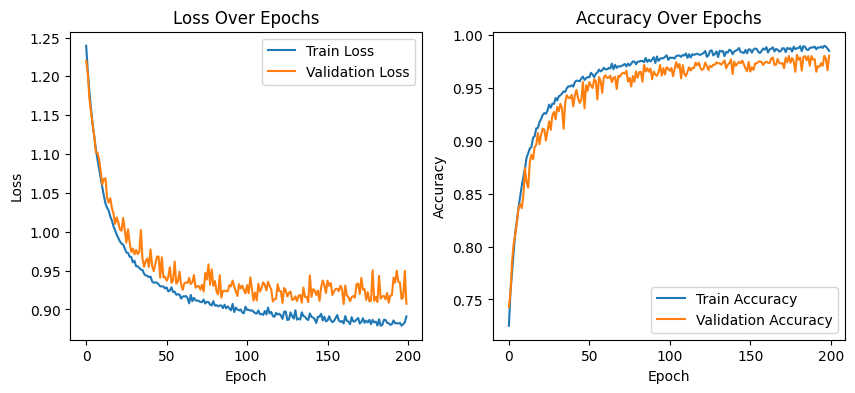

In [153]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_before_pruning.history['loss'], label='Train Loss')
plt.plot(history_before_pruning.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_before_pruning.history['accuracy'], label='Train Accuracy')
plt.plot(history_before_pruning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [154]:
# Convert to TensorFlow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open( directory_name+"/saved/classification.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8j9qgvby\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8j9qgvby\assets


 14/155 [=>............................] - ETA: 0s - loss: 0.9177 - accuracy: 0.9688

155/155 [==============================] - 0s 2ms/step - loss: 0.9073 - accuracy: 0.9804
Test Loss: 0.9073, Test Accuracy: 0.9804


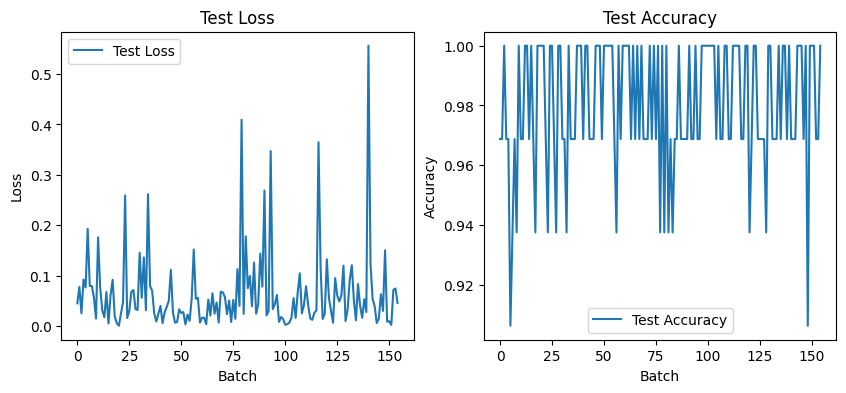

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate average loss and accuracy
test_losses = []
test_accuracies = []

for signals_batch, labels_batch in test_dataset:
    predictions = model(signals_batch)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
    acc = tf.keras.metrics.sparse_categorical_accuracy(labels_batch, predictions)
    test_losses.append(np.mean(loss))
    test_accuracies.append(np.mean(acc))

# Draw the test loss curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot the test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## After pruning

In [156]:
# Define the model
model = tf.keras.models.Sequential([
    layers.Reshape((100, 3, 1), input_shape=(100, 3)),  # Reshape input for Conv2D #163216-》8 16 16
    layers.Conv2D(16, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(32, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(2, activation='softmax')  
])

In [157]:
# Suppose auxiliary_input is a tensor of shape (batch_size, input_dim).
model.compile(optimizer='adam',
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0),
              metrics=['accuracy'])

In [158]:
train_labels.shape

(19820, 1)

In [159]:
import tensorflow_model_optimization as tfmot
# from tensorflow import keras
epoches = 50
batch_size = 128
num_train = train_labels.shape[0] * (1 - validation_split) 
end_step = np.ceil(num_train / batch_size).astype(np.int32) * epoches
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.50,
    final_sparsity=0.80,
    begin_step=0,
    end_step=end_step
)

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # tfmot.sparsity.keras.PruningSummaries(log_dir='./logs')
]

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

model_for_pruning.compile(optimizer='adam',   loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 1), metrics=['accuracy'])

In [160]:
history_after_pruning = model_for_pruning.fit(train_dataset, validation_data=test_dataset, epochs=epoches, callbacks=callbacks)

Epoch 1/50


620/620 [==============================] - 6s 7ms/step - loss: 1.2468 - accuracy: 0.7207 - val_loss: 1.2328 - val_accuracy: 0.7273
Epoch 2/50
620/620 [==============================] - 3s 6ms/step - loss: 1.2231 - accuracy: 0.7450 - val_loss: 1.2296 - val_accuracy: 0.7411
Epoch 3/50
620/620 [==============================] - 3s 5ms/step - loss: 1.2155 - accuracy: 0.7525 - val_loss: 1.2189 - val_accuracy: 0.7558
Epoch 4/50
620/620 [==============================] - 3s 5ms/step - loss: 1.2080 - accuracy: 0.7613 - val_loss: 1.2089 - val_accuracy: 0.7584
Epoch 5/50
620/620 [==============================] - 3s 5ms/step - loss: 1.2015 - accuracy: 0.7688 - val_loss: 1.2225 - val_accuracy: 0.7483
Epoch 6/50
620/620 [==============================] - 4s 6ms/step - loss: 1.1977 - accuracy: 0.7689 - val_loss: 1.2019 - val_accuracy: 0.7673
Epoch 7/50
620/620 [==============================] - 4s 6ms/step - loss: 1.1928 - accuracy: 0.7724 - val_loss: 1.1983 - val_accuracy: 0.7689
Epoch 8/50
620/62

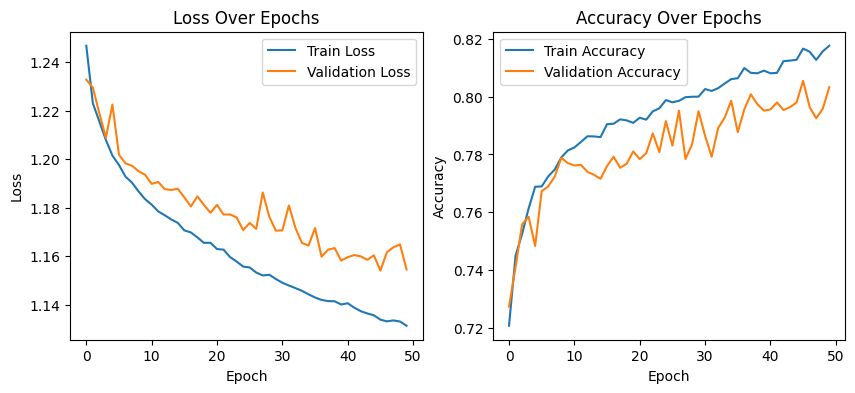

In [161]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_after_pruning.history['loss'], label='Train Loss')
plt.plot(history_after_pruning.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_after_pruning.history['accuracy'], label='Train Accuracy')
plt.plot(history_after_pruning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [162]:
# Convert to TensorFlow lite
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model = converter.convert()

with open(directory_name+"/saved/classification_pruning.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpaz10gm0l\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpaz10gm0l\assets


### Convert to quantized TensorFlow Lite

In [163]:
def representative_data_gen():
    for input_data, _ in train_dataset.take(len(train_signals)):
        input_data = tf.cast(input_data, dtype=tf.float32)
        
        # Remove the last dimension and make it shape (32, 100, 3)
        input_data = tf.squeeze(input_data, axis=-1)
        
        # The shape of the input needs to be (1, 100, 3) corresponding to the model input (None, 100, 3)
        for i in range(input_data.shape[0]):  # Travers batch_size
            yield [input_data[i:i+1]]  # Keep batch_size = 1

In [164]:
for input_data, _ in train_dataset.take(1):
    print(input_data.shape)

(32, 100, 3, 1)


In [165]:
## https://github.com/tensorflow/tensorflow/issues/53101

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(
    directory_name+ "/saved/classification_q.tflite", "wb"
) as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpmtfgusfy\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpmtfgusfy\assets
c:\Users\Administrator\.platformio\penv\Lib\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## Testing

  1/943 [..............................] - ETA: 11s - loss: 1.9127e-05 - accuracy: 1.0000

943/943 [==============================] - 1s 1ms/step - loss: 0.0683 - accuracy: 0.9872
Test Loss: 0.0683, Test Accuracy: 0.9872


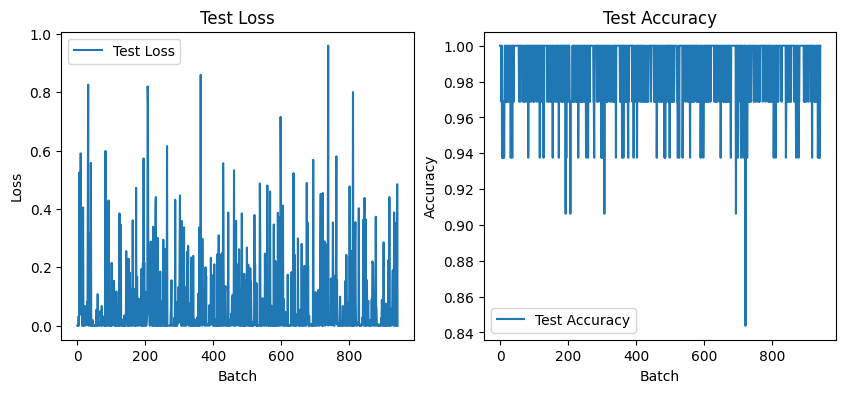

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# test model
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#Calculate average loss and accuracy
test_losses = []
test_accuracies = []

for signals_batch, labels_batch in test_dataset:
    predictions = model(signals_batch)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
    acc = tf.keras.metrics.sparse_categorical_accuracy(labels_batch, predictions)
    test_losses.append(np.mean(loss))
    test_accuracies.append(np.mean(acc))

# Draw the test loss curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# 绘制测试准确率曲线
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [17]:
prediction = model.predict(signals[100].reshape(1,100,1))
prediction

1/1 [==============================] - 0s 104ms/step


array([[0.17232643, 0.82767355]], dtype=float32)

In [18]:
labels[100]

array([1.])

In [33]:
random_input = np.arange(0,100)
random_input.reshape(1,100,1)
prediction = model.predict(tf.expand_dims(random_input, axis=0))
prediction

1/1 [==============================] - 0s 84ms/step


array([[0.9747999 , 0.02520015]], dtype=float32)

In [39]:
random_input.size

100

In [26]:
random_input = np.random.rand(100,1)
prediction = model.predict(tf.expand_dims(random_input, axis=0))
prediction

1/1 [==============================] - 0s 90ms/step


array([[0.18920052]], dtype=float32)

In [27]:
for signals_batch, labels_batch in test_dataset.take(1):
    print("Data batch shape:", signals_batch.shape)
    print("Label batch shape:", labels_batch.shape) 

Data batch shape: (32, 100, 1)
Label batch shape: (32, 1)
